In [0]:
from google.cloud import storage
import tarfile
import numpy as np
from PIL import Image
import io
from matplotlib import pylab as plt

In [0]:
# !conda update wrapt

In [0]:
# !pip install tensorflow

In [0]:
import tensorflow as tf

/opt/conda/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Connect with GCS bucket

In [0]:
bucket_name = "dataproc-staging-us-central1-759291875656-wohgf1sk"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

In [0]:
file_prefix = "data/"
blobs = bucket.list_blobs(prefix=file_prefix, delimiter = '/')

In [0]:
# list files in folder
for blob in blobs:
    print(blob.name)

data/filelist_places365-standard.tar
data/test_data.tar
data/train_data.tar
data/val_data.tar


#### Download file from blob

In [0]:
file_name = "val_data.tar"
blob = bucket.get_blob(file_prefix + file_name)
blob.download_to_filename("small_data.tar")

In [0]:
# test small amount of images
TEST_NUM_IMAGES = 10000

image_byte = []
tar_file = tarfile.open("small_data.tar")

num = 0
for member in tar_file.getmembers():
    if num <= TEST_NUM_IMAGES:
        f = tar_file.extractfile(member)
        if f is not None:
            content = f.read()
            image_byte.append(content)
        num += 1
    else:
        break
tar_file.close()

In [0]:
data = image_byte

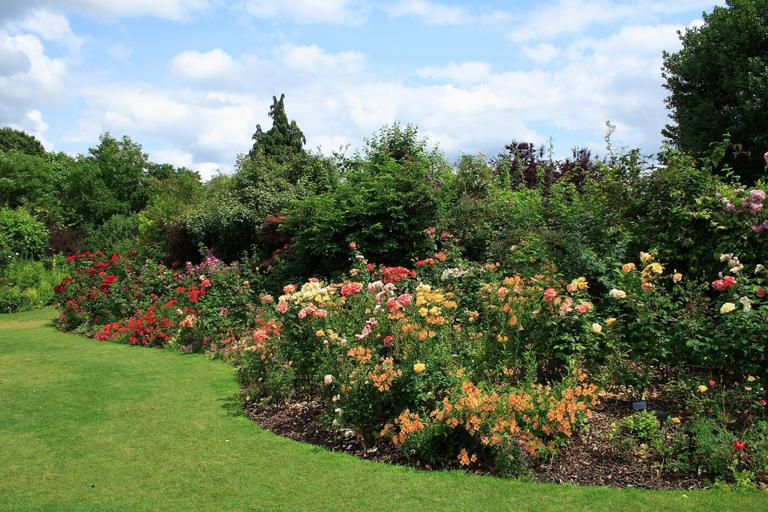

In [0]:
Image.open(io.BytesIO(data[1]))

### Resize, convert and flatten image data into array

In [0]:
def convert_img(img_data, dim_h):
    """ 
  Resize image so that it has height dim_h and flatten the image
  Args:
    img_data: (bytes) image data
    dim_h: (int) desired height
  Returns:
    img: (np array) the resized and flattened image
    """
    img = Image.open(io.BytesIO(img_data))
#     img = img.convert(mode = 'L') # convert to grey scale
    img = img.resize((dim_h, dim_h), Image.ANTIALIAS)
    im_flatten = np.reshape(np.array(img),(-1,))
    
    return im_flatten

In [0]:
flatten_data = np.array([convert_img(i, 512) for i in data])
flatten_data.shape

### Implement KPCA

In [0]:
flatten_data_tf = tf.convert_to_tensor(flatten_data)
flatten_data_tf.shape

TensorShape([100, 786432])

In [0]:
# RBF Kernel PCA
# reference:https://towardsdatascience.com/kernel-pca-vs-pca-vs-ica-in-tensorflow-sklearn-60e17eb15a64
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]  
    gamma: float
        Tuning parameter of the RBF kernel    
    n_components: int
        Number of principal components to return    
    Returns
    ------------
    top_eigvec: {NumPy ndarray}, shape = [n_examples, k_features]   
    """
    # Calculate pairwise squared Euclidean distances
    # Non-loop distance calculation: https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c
    X = tf.dtypes.cast(X,tf.float64)
    distance_matric = -2 * tf.matmul(X, tf.transpose(X)) + \
                      tf.reduce_sum(X**2, axis = 1) + \
                      tf.expand_dims(tf.reduce_sum(X**2, axis = 1),1)
    
    # Compute the symmetric kernel matrix.
    k = tf.exp(-gamma * distance_matric)  
    
    # Center the kernel matrix.
    N = k.shape[0]
    ones = tf.ones([N,N], dtype = tf.float64)/N
    center_k = k - tf.matmul(ones, k) - tf.matmul(k, ones)+tf.matmul(tf.matmul(ones,k),ones)
    
    # Obtaining eigenpairs from the centered kernel matrix
    eigval, eigvec = tf.linalg.eigh(center_k)
    
    # Collect the top k eigenvectors (projected examples)
    top_eigvec = eigvec[:, -n_components:]
    
    return top_eigvec  

In [0]:
kpca = rbf_kernel_pca(flatten_data_tf, 10, 15)

In [0]:
kpca.shape

TensorShape([100, 15])

In [0]:
from google.cloud import storage
import tarfile
import numpy as np
from PIL import Image
import io
from matplotlib import pylab as plt

# !conda update wrapt

# !pip install tensorflow

import tensorflow as tf

#### Connect with GCS bucket

bucket_name = "dataproc-staging-us-central1-759291875656-wohgf1sk"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_prefix = "data/"
blobs = bucket.list_blobs(prefix=file_prefix, delimiter = '/')

# list files in folder
for blob in blobs:
    print(blob.name)

#### Download file from blob

file_name = "val_data.tar"
blob = bucket.get_blob(file_prefix + file_name)
blob.download_to_filename("small_data.tar")

# test small amount of images
TEST_NUM_IMAGES = 10000

image_byte = []
tar_file = tarfile.open("small_data.tar")

num = 0
for member in tar_file.getmembers():
    if num <= TEST_NUM_IMAGES:
        f = tar_file.extractfile(member)
        if f is not None:
            content = f.read()
            image_byte.append(content)
        num += 1
    else:
        break
tar_file.close()

data = image_byte

Image.open(io.BytesIO(data[1]))

### Resize, convert and flatten image data into array

def convert_img(img_data, dim_h):
    """ 
  Resize image so that it has height dim_h and flatten the image
  Args:
    img_data: (bytes) image data
    dim_h: (int) desired height
  Returns:
    img: (np array) the resized and flattened image
    """
    img = Image.open(io.BytesIO(img_data))
#     img = img.convert(mode = 'L') # convert to grey scale
    img = img.resize((dim_h, dim_h), Image.ANTIALIAS)
    im_flatten = np.reshape(np.array(img),(-1,))
    
    return im_flatten

flatten_data = np.array([convert_img(i, 512) for i in data])
flatten_data.shape

### Implement KPCA

flatten_data_tf = tf.convert_to_tensor(flatten_data)
flatten_data_tf.shape

# RBF Kernel PCA
# reference:https://towardsdatascience.com/kernel-pca-vs-pca-vs-ica-in-tensorflow-sklearn-60e17eb15a64
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]  
    gamma: float
        Tuning parameter of the RBF kernel    
    n_components: int
        Number of principal components to return    
    Returns
    ------------
    top_eigvec: {NumPy ndarray}, shape = [n_examples, k_features]   
    """
    # Calculate pairwise squared Euclidean distances
    # Non-loop distance calculation: https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c
    X = tf.dtypes.cast(X,tf.float64)
    distance_matric = -2 * tf.matmul(X, tf.transpose(X)) + \
                      tf.reduce_sum(X**2, axis = 1) + \
                      tf.expand_dims(tf.reduce_sum(X**2, axis = 1),1)
    
    # Compute the symmetric kernel matrix.
    k = tf.exp(-gamma * distance_matric)  
    
    # Center the kernel matrix.
    N = k.shape[0]
    ones = tf.ones([N,N], dtype = tf.float64)/N
    center_k = k - tf.matmul(ones, k) - tf.matmul(k, ones)+tf.matmul(tf.matmul(ones,k),ones)
    
    # Obtaining eigenpairs from the centered kernel matrix
    eigval, eigvec = tf.linalg.eigh(center_k)
    
    # Collect the top k eigenvectors (projected examples)
    top_eigvec = eigvec[:, -n_components:]
    
    return top_eigvec  

kpca = rbf_kernel_pca(flatten_data_tf, 10, 15)

kpca.shape